Import necessary libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

Import the data

In [2]:
df_train = pd.read_csv("IMDB Dataset.csv")
df_train.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Selecting required columns and rows

In [3]:
from io import StringIO

col = ['sentiment', 'review']
df_train = df_train[col]
df_train = df_train[pd.notnull(df_train['review'])]
df_train.columns = ['sentiment', 'review']

df_train['category_id'] = df_train['sentiment'].factorize()[0]

category_id_df_train = df_train[['sentiment', 'category_id']].drop_duplicates().sort_values('category_id')

category_to_id = dict(category_id_df_train.values)

id_to_category = dict(category_id_df_train[['category_id', 'sentiment']].values)

df_train.head()

,sentiment,review,category_id
0,positive,One of the other reviewers has mentioned that ...,0
1,positive,A wonderful little production. <br /><br />The...,0
2,positive,I thought this was a wonderful way to spend ti...,0
3,negative,Basically there's a family where a little boy ...,1
4,positive,"Petter Mattei's ""Love in the Time of Money"" is...",0


In [6]:
df_train['review'][7]

"This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny anymore, and it's continued its decline further to the complete waste of time it is today.<br /><br />It's truly disgraceful how far this show has fallen. The writing is painfully bad, the performances are almost as bad - if not for the mildly entertaining respite of the guest-hosts, this show probably wouldn't still be on the air. I find it so hard to believe that the same creator that hand-selected the original cast also chose the band of hacks that followed. How can one recognize such brilliance and then see fit to replace it with such mediocrity? I felt I must give 2 stars out of respect for the original cast that made this show such a huge success. As it is now, the show is just awful. I can't believe it's still on the air."

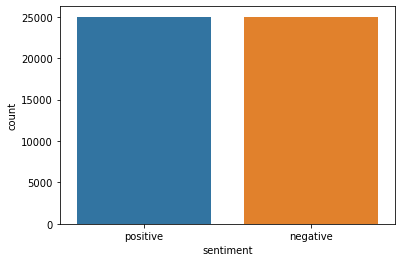

In [4]:
import seaborn as sns

sns.countplot(x='sentiment', data=df_train)

Data Preprocessing

In [7]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [8]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

We will preprocess our reviews

In [9]:
X = []
sentences = list(df_train['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [10]:
X[7]

'This show was an amazing fresh innovative idea in the when it first aired The first or years were brilliant but things dropped off after that By the show was not really funny anymore and it continued its decline further to the complete waste of time it is today It truly disgraceful how far this show has fallen The writing is painfully bad the performances are almost as bad if not for the mildly entertaining respite of the guest hosts this show probably wouldn still be on the air find it so hard to believe that the same creator that hand selected the original cast also chose the band of hacks that followed How can one recognize such brilliance and then see fit to replace it with such mediocrity felt must give stars out of respect for the original cast that made this show such huge success As it is now the show is just awful can believe it still on the air '

We only have two labels in the output i.e. "positive" and "negative"

In [11]:
y = df_train['category_id']

Spliting the data into training and test sets

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Get the frequently occurring words

In [13]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

dictionary containing words and their index

In [14]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Use GloVe embeddings to create our feature matrix

In [15]:
from numpy import array
from numpy import asarray
from numpy import zeros

In [16]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

Model building and predicting

In [17]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Text Classification with Simple Neural Network

In [18]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

Use adam optimizer

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          9254700   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10001     
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


We are now fitting our model to the data. Here we have 6 epochs and a batch size of 128 patterns.

In [20]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 2s 7ms/step - loss: 0.6162 - acc: 0.6607 - val_loss: 0.5378 - val_acc: 0.7312
Epoch 2/6
250/250 [==============================] - 1s 6ms/step - loss: 0.4993 - acc: 0.7581 - val_loss: 0.5316 - val_acc: 0.7336
Epoch 3/6
250/250 [==============================] - 1s 6ms/step - loss: 0.4641 - acc: 0.7853 - val_loss: 0.5386 - val_acc: 0.7319
Epoch 4/6
250/250 [==============================] - 2s 7ms/step - loss: 0.4391 - acc: 0.7977 - val_loss: 0.5194 - val_acc: 0.7436
Epoch 5/6
250/250 [==============================] - 2s 6ms/step - loss: 0.4242 - acc: 0.8059 - val_loss: 0.5255 - val_acc: 0.7460
Epoch 6/6
250/250 [==============================] - 2s 8ms/step - loss: 0.4089 - acc: 0.8138 - val_loss: 0.5292 - val_acc: 0.7459


model evaluation

In [21]:
score = model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.5331 - acc: 0.7437


Check test accuracy and loss

In [22]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5330575108528137
Test Accuracy: 0.7437000274658203


Plot the accuracy and loss differences for training and test sets

In [23]:
import matplotlib.pyplot as plt

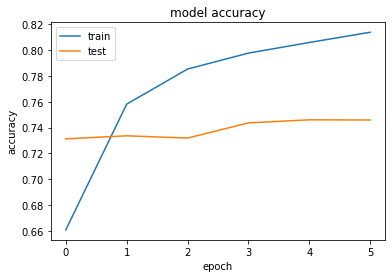

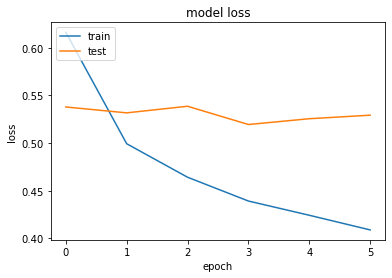

In [24]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])


plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
